## Zadanie domowe: Projektowanie filtru metodą okien

Zauważone w zadaniu z filtracją artefakty są efektem zastosowania filtru idealnego (wycięcia odpowiednich częstotliwości).
Aby je usunąć, należy filtr idealny w dziedzinie przestrzennej przemnożyć przez dwuwymiarowe okno (stworzone na podstawie jednowymiarowego).

1. Zdefiniuj rozmiar filtra (np. 21).

2. Stwórz okno np. Hamminga (`np.Hmming`) o zadanym rozmiarze.

3. Na podstawie tego okna stwórz okno dwuwymiarowe: $F = f^Tf$.
Można to zrealizować prostą instrukcją:
        hanning2d = np.outer(hanning, hanning)

4. Stwórz wzorcowy filtr idealny tak samo jak w poprzednim ćwiczeniu.
Jego rozmiar musi być taki sam jak zdefiniowany w punkcie pierwszym.

5. Generalna zasada jest taka, że należy obliczyć odwrotną transformatę Fouriera filtru idealnego.
Aby zagwarantować jednak dobrą lokalizację i symetryczność tworzonego filtru wykorzystuje się dodatkowe rotacje i przesunięcia.

        FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
        FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
        FilterFidft = cv2.idft(np.float32(FilterFRot3),
                        flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
        FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

6. Aby otrzymać poprawny filtr należy teraz pomnożyć dwuwymiarowe okno ze stworzonym filtrem idealnym w dziedzinie przestrzennej.

7. Stworzony filtr powinien zostać znowu przeniesiony do dziedziny częstotliwości.
Należy jednak rozszerzyć go tak, aby miał taki sam rozmiar jak filtrowany obraz.
Operację tę wykonaj tak samo jak w poprzednim ćwiczeniu (`cv2.copyMakeBorder`).
Oblicz transformatę Fouriera i wykonaj przesunięcie.
Następnie oblicz wartość bezwzględną (dzięki temu filtr nie będzie wpływał na fazę).
Wynikiem jest poprawiony filtr w dziedzinie częstotliwości.

8. Przeprowadź filtrację obrazu *lena.bmp* za pomocą zaprojektowanego filtra.
Wyświetl filtr, oraz wynik filtracji.
Do wyświetlenia filtru możesz użyć przestrzeń częstotliwości wygenerowaną w poprzednim zadaniu (*FSpaceRowsM* i *FSpaceColsM*).

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/'

fileNames = ["lena.bmp"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)


C:\Users\Tomek\AppData\Local\Temp\ipykernel_13896\16567811.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Tomek\AppData\Local\Temp\ipykernel_13896\16567811.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figFilter.show()


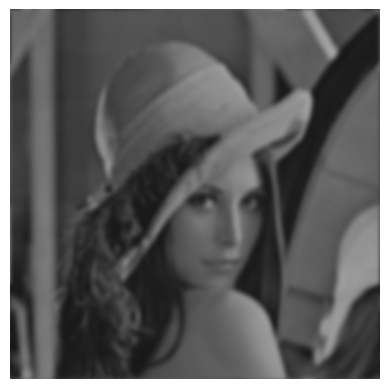

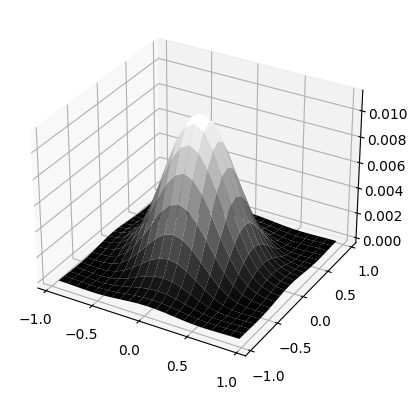

In [14]:
# read lena image
I_Lena = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
I_FI = cv2.dft(src=np.float32(I_Lena), flags=cv2.DFT_COMPLEX_OUTPUT)
I_shift = np.fft.fftshift(I_FI, [0,1])

# create Hamming window
filter_size = 21
hamming = np.hamming(filter_size)
hamming2d = np.outer(hamming, hamming)

# create ideal filter (same size as above)
FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(filter_size))
FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, filter_size]))
FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(filter_size))
FSpaceColsM = np.outer(np.ones([1, filter_size]), FSpaceCols)

FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))
FilterF = FreqR <= 0.1

# calculate IFT of the ideal filter
# guarantee good location and symmetry
FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
FilterFidft = cv2.idft(np.float32(FilterFRot3),
                flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

# get correct filter = 2d window * ideal filter
correct_filter = hamming2d * FilterFI

# calculate magnitude
# but first, extend to the size of the filtered image
correct_filter_border = cv2.copyMakeBorder(correct_filter, 0, I_Lena.shape[0] - correct_filter.shape[0], 0, I_Lena.shape[1] - correct_filter.shape[1], cv2.BORDER_CONSTANT, value=0)
# FT and shift
correct_filter_dft = cv2.dft(src=np.float32(correct_filter_border), flags=cv2.DFT_COMPLEX_OUTPUT)
correct_filter_shift = np.fft.fftshift(correct_filter_dft, [0,1])
# abs to not influence phase
correct_filter_abs = np.abs(correct_filter_shift)
filter_ifft = cv2.magnitude(correct_filter_abs[:, :, 0], correct_filter_abs[:, :, 1])

# filter image
FilterF3 = np.repeat(filter_ifft[:, :, np.newaxis], 2, axis=2)
filtration = I_shift * FilterF3

I_ishift = np.fft.ifftshift(filtration, [0, 1])
ifft = cv2.idft(I_ishift, flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
imgIFFT = cv2.magnitude(ifft[:, :, 0], ifft[:, :, 1])
imgIFFT = np.abs(imgIFFT)

# filtered image
fig, axs = plt.subplots(1, 1)

axs.imshow(imgIFFT, 'gray', vmin=0, vmax=256)
axs.axis('off')

fig.show()

# filter
figFilter = plt.figure()
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, correct_filter, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)
figFilter.show()